##Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# specify the desired data location to the current working directory
%cd /content/drive/MyDrive/Dataset

/content/drive/.shortcut-targets-by-id/1hQJhZXCBbc369GWFH06FCrflHQ8EO2xS/Dataset


In [3]:
# Keras prepocessing library
! pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


##Import Library

In [4]:
# Get the required Library
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50V2, VGG16

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np

import os
from tensorflow.keras import layers
from collections import defaultdict
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

##Data Exploration

In [6]:
os.listdir('/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split300/Training')

['Abstract', 'Realism', 'Expressionism', 'Romanticism', 'Symbolism']

In [7]:
os.listdir('/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split300/Validation')

['Abstract', 'Realism', 'Expressionism', 'Romanticism', 'Symbolism']

In [8]:
train_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split300/Training'
validation_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split300/Validation'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode = 'categorical',
                                             image_size = IMG_SIZE,
                                             batch_size = BATCH_SIZE,
                                             shuffle = True)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode ='categorical',
                                                  image_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True)


Found 1200 files belonging to 5 classes.
Found 300 files belonging to 5 classes.


In [9]:
# Fungsi untuk histogram equalization
def histogram_equalization(image):
    image = np.array(image)
    if len(image.shape) == 3 and image.shape[2] == 3:  # RGB image
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    elif len(image.shape) == 2:  # Grayscale image
        image = cv2.equalizeHist(image)
    return image

#def histogram_equalization_wrapper(image):
    image = tf.numpy_function(histogram_equalization, [image], tf.uint8)
    return image

Found 1200 files belonging to 5 classes.
['Abstract', 'Expressionism', 'Realism', 'Romanticism', 'Symbolism']


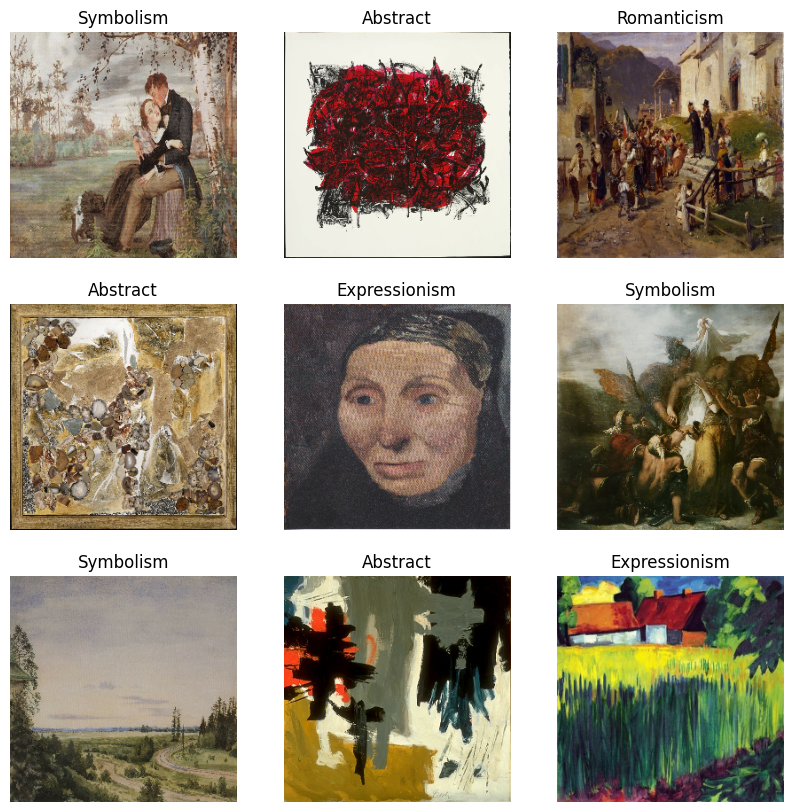

In [10]:
data = image_dataset_from_directory(train_dir)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Data Preprocessing

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

##Architecture

###Load MobileNetV2 Pretrained Model

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [13]:
feature, target = next(iter(train_dataset))
feature_batch = base_model(feature)
print(feature_batch.shape)

(32, 7, 7, 1280)


###Freeze Layer

In [14]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


###Create New Dense Layer

In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(5, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = tf.keras.Model(inputs, x)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

###Training Preperation

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

###Training

In [19]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[es_callback])

Epoch 1/100
38/38 [==============================] - 399s 10s/step - loss: 1.7983 - accuracy: 0.2208 - val_loss: 1.6064 - val_accuracy: 0.3200
Epoch 2/100
38/38 [==============================] - 27s 574ms/step - loss: 1.6430 - accuracy: 0.2675 - val_loss: 1.5610 - val_accuracy: 0.4100
Epoch 3/100
38/38 [==============================] - 27s 607ms/step - loss: 1.5857 - accuracy: 0.3150 - val_loss: 1.5149 - val_accuracy: 0.4667
Epoch 4/100
38/38 [==============================] - 26s 603ms/step - loss: 1.5447 - accuracy: 0.3383 - val_loss: 1.4645 - val_accuracy: 0.4967
Epoch 5/100
38/38 [==============================] - 27s 623ms/step - loss: 1.4822 - accuracy: 0.3825 - val_loss: 1.4118 - val_accuracy: 0.5267
Epoch 6/100
38/38 [==============================] - 26s 590ms/step - loss: 1.4439 - accuracy: 0.4083 - val_loss: 1.3571 - val_accuracy: 0.5667
Epoch 7/100
38/38 [==============================] - 33s 778ms/step - loss: 1.3971 - accuracy: 0.4425 - val_loss: 1.3025 - val_accuracy: 

###Plot Loss And Accuracy

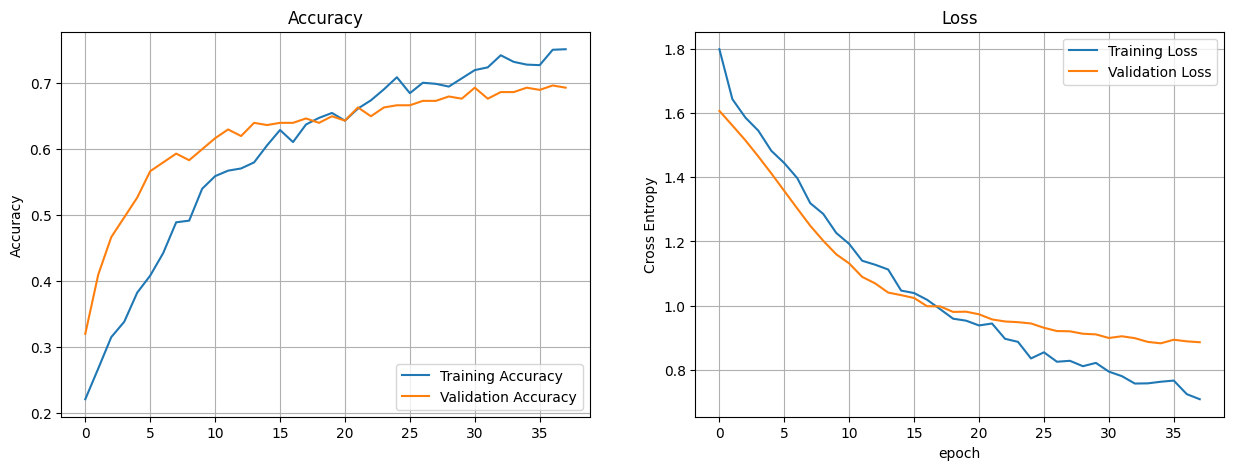

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

###Fine Tuning

In [21]:
base_model.trainable = True

In [22]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [25]:
fine_tune_epochs = 100
total_epochs =  21 + fine_tune_epochs
print(total_epochs)

121


In [26]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es_callback])

Epoch 38/121
38/38 [==============================] - 40s 623ms/step - loss: 0.7219 - accuracy: 0.7517 - val_loss: 0.8663 - val_accuracy: 0.6933
Epoch 39/121
38/38 [==============================] - 26s 602ms/step - loss: 0.6882 - accuracy: 0.7533 - val_loss: 0.8398 - val_accuracy: 0.7133
Epoch 40/121
38/38 [==============================] - 27s 611ms/step - loss: 0.6432 - accuracy: 0.7725 - val_loss: 0.8451 - val_accuracy: 0.7033
Epoch 41/121
38/38 [==============================] - 31s 728ms/step - loss: 0.6371 - accuracy: 0.7825 - val_loss: 0.8494 - val_accuracy: 0.7133
Epoch 42/121
38/38 [==============================] - 26s 605ms/step - loss: 0.6033 - accuracy: 0.7917 - val_loss: 0.8053 - val_accuracy: 0.7233
Epoch 43/121
38/38 [==============================] - 28s 656ms/step - loss: 0.5739 - accuracy: 0.7942 - val_loss: 0.7933 - val_accuracy: 0.7433
Epoch 44/121
38/38 [==============================] - 26s 598ms/step - loss: 0.5263 - accuracy: 0.8175 - val_loss: 0.8096 - val_ac

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

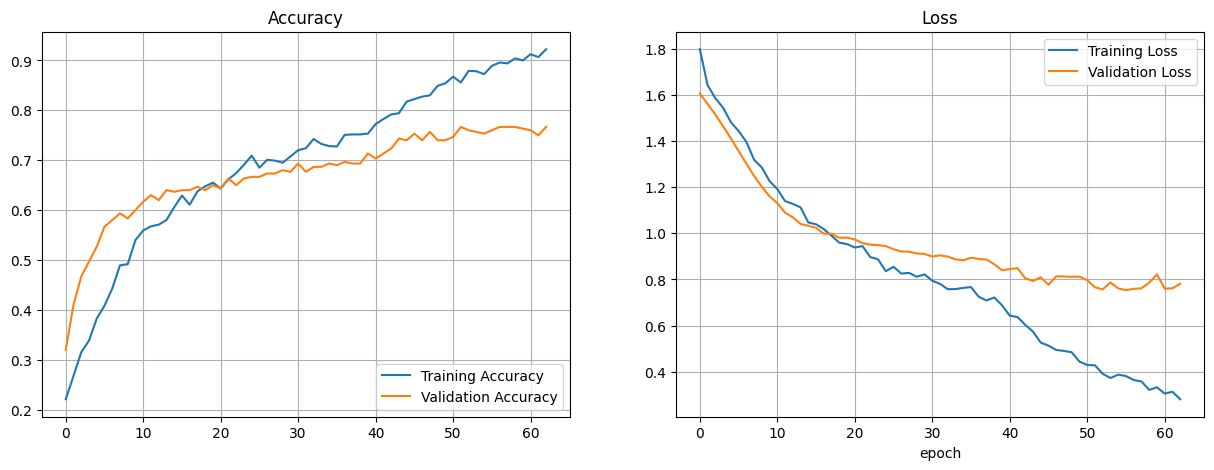

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
base_model.trainable = True

In [30]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
# Menggunakan callback EarlyStopping dan ReduceLROnPlateau
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [33]:
# Melatih model dengan dataset yang sudah di-augmentasi
history_fine = model.fit(train_dataset,
                         epochs=121,  # Total epoch yang ingin dilanjutkan
                         initial_epoch=20,  # Memulai dari epoch ke-20
                         validation_data=validation_dataset,
                         callbacks=[es_callback, reduce_lr])

Epoch 21/121
38/38 [==============================] - 43s 756ms/step - loss: 0.2659 - accuracy: 0.9267 - val_loss: 0.7607 - val_accuracy: 0.7800 - lr: 1.0000e-06
Epoch 22/121
38/38 [==============================] - 31s 715ms/step - loss: 0.2572 - accuracy: 0.9258 - val_loss: 0.7640 - val_accuracy: 0.7733 - lr: 1.0000e-06
Epoch 23/121
38/38 [==============================] - 28s 647ms/step - loss: 0.2445 - accuracy: 0.9375 - val_loss: 0.7871 - val_accuracy: 0.7767 - lr: 1.0000e-06
Epoch 24/121
38/38 [==============================] - 26s 600ms/step - loss: 0.2475 - accuracy: 0.9333 - val_loss: 0.7749 - val_accuracy: 0.7767 - lr: 1.0000e-06
Epoch 25/121
38/38 [==============================] - 31s 717ms/step - loss: 0.2548 - accuracy: 0.9233 - val_loss: 0.7761 - val_accuracy: 0.7800 - lr: 2.0000e-07
Epoch 26/121
38/38 [==============================] - 27s 610ms/step - loss: 0.2418 - accuracy: 0.9342 - val_loss: 0.7767 - val_accuracy: 0.7800 - lr: 2.0000e-07
Epoch 27/121
38/38 [========

In [38]:
# Save the model
model.save('model9_ArtNaon.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/Dataset/Model')

In [36]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("model9_ArtNaon.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step


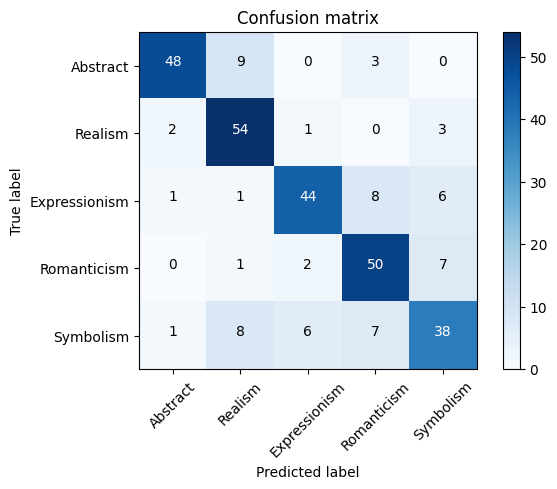

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/Model/model9_ArtNaon.h5')

# Menghitung jumlah sampel dalam dataset validasi
validation_samples = 0
for images, labels in validation_dataset:
    validation_samples += len(labels)

# Fungsi untuk mendapatkan prediksi dari model
def get_predictions_and_labels(dataset, model):
    predictions = []
    labels = []
    for images, batch_labels in dataset:
        batch_predictions = model.predict(images)
        predictions.extend(np.argmax(batch_predictions, axis=1))
        labels.extend(np.argmax(batch_labels, axis=1))
    return np.array(predictions), np.array(labels)

# Dapatkan prediksi dan label dari validation_dataset
Y_pred_classes, Y_true = get_predictions_and_labels(validation_dataset, model)

# Hitung confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Nama kelas (sesuaikan dengan kelas Anda)
class_names = ['Abstract', 'Realism', 'Expressionism', 'Romanticism', 'Symbolism']

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Fungsi ini mencetak dan menampilkan confusion matrix.
    Normalisasi bisa diterapkan dengan mengatur `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix dengan nama kelas
plot_confusion_matrix(confusion_mtx, classes=class_names)

# Menampilkan plot
plt.show()


1/1 [==============================] - 0s 31ms/step


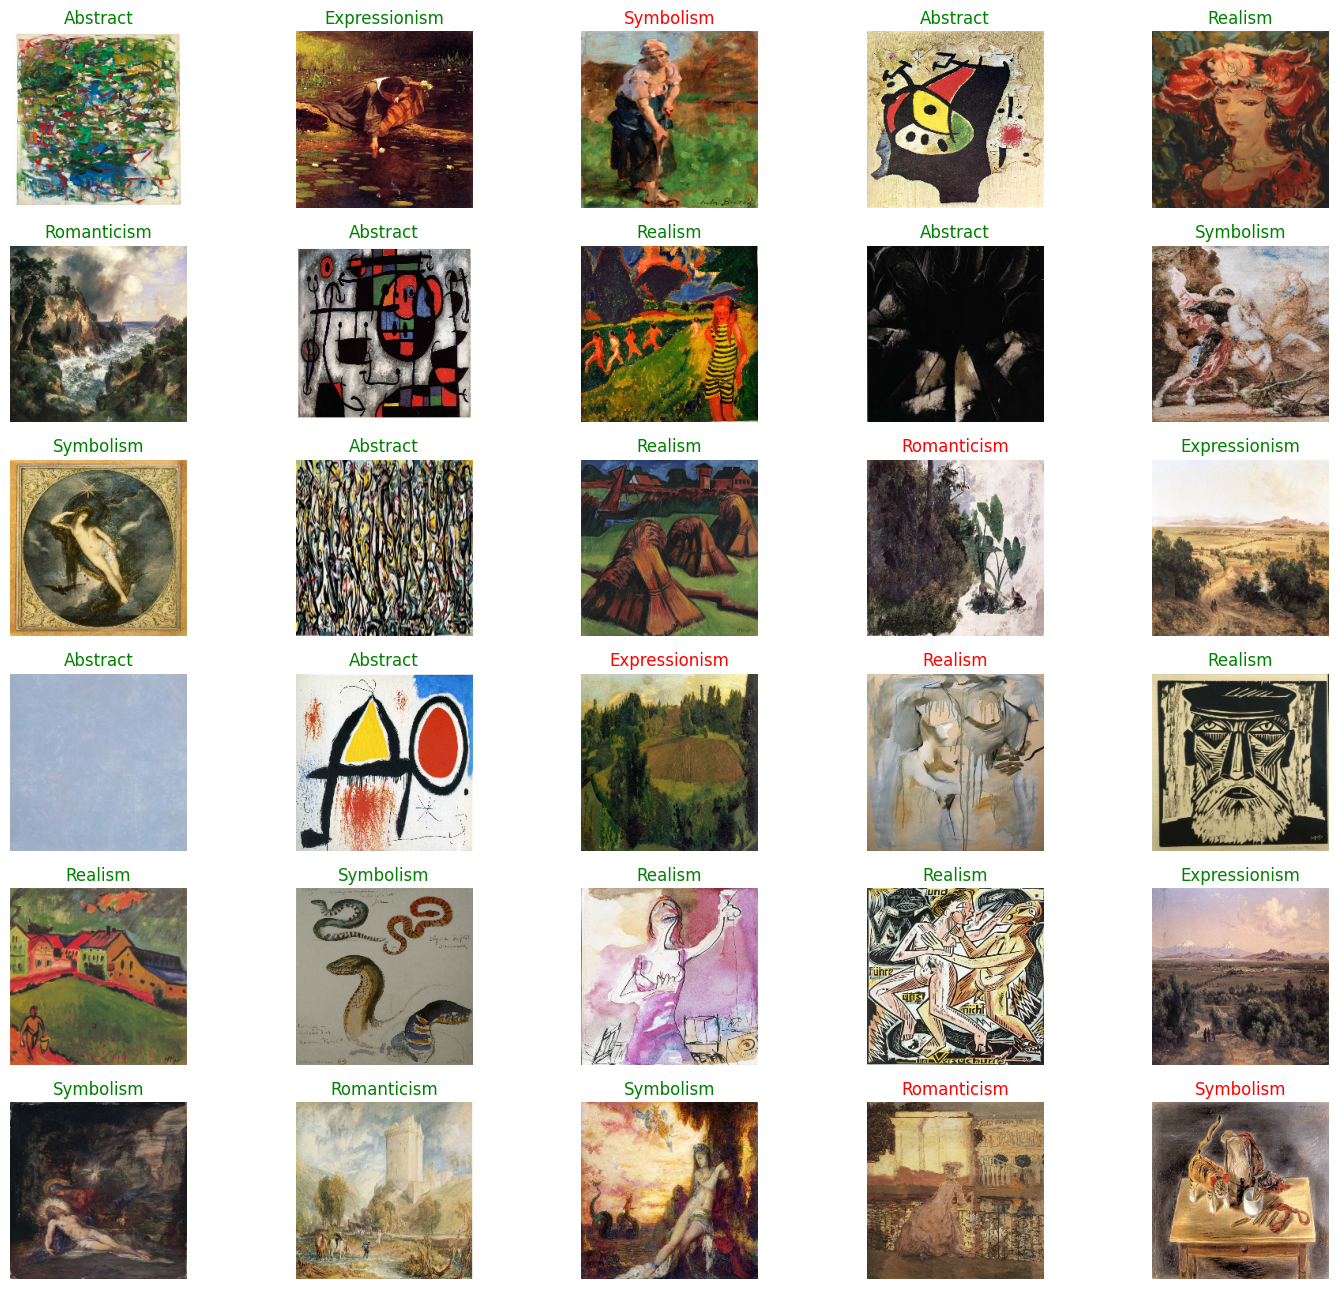

In [46]:
# Mendapatkan satu batch dari validation dataset untuk plot gambar
img, labels = next(iter(validation_dataset))

# Define the class indices (mapping) as obtained previously
class_indices = {'Abstract': 0,'Realism':1, 'Expressionism':2, 'Romanticism':3, 'Symbolism':4}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()